# Deeplearning - Nasir Hussain - 2021/08/28

# 10 Deep learning for timeseries

## 10.1 Different kinds of timeseries tasks

- A timeseries
  - any data obtained via measurements at regular intervals
    - daily price of a stock
    - hourly electricity consumption of a city
    - weekly sales of a store
    - natural phenomena
      - seismic activity
      - evolution of fish populations in a river
      - weather at a location
    - human activity patterns
      - visitors to a website
      - country’s GDP
      - credit card transactions)
  - working with timeseries involves understanding the dynamics of a system
    - periodic cycles
    - how it trends over time
    - its regular regime
    - its sudden spikes
  - Tasks realted to time series
    - forecasting
      - predicting what will happen next in a series
    - classification
      - Assign one or more categorical labels to a timeseries
    - Event detection
      - Identify the occurrence of a specific expected event within a continuous data stream
    - Anomaly detection
      - Detect anything unusual happening within a continuous datastream
  -  data-representation techniques
    - Fourier transform
      - expressing a series of values in terms of a superposition of waves of different frequencies
      - preprocessing any data that is primarily characterized by its cycles and oscillations
        - sound
        - the vibrations of the frame of a skyscraper
        - brain waves


## 10.2 A temperature-forecasting example

- predict the temperature 24 hours in the future
  - given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity
  - use recurrent neural networks (RNNs)

In [1]:
# download data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-05-26 11:38:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.225.40
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.225.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  56.2MB/s    in 0.2s    

2022-05-26 11:38:09 (56.2 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
# Listing 10.1 Inspecting the data of the Jena weather dataset
import os
fname = os.path.join("jena_climate_2009_2016.csv")
 
with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
# Listing 10.2 Parsing the data
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  # We store column 1 in the “temperature” array.
  temperature[i] = values[1]
  # We store all columns (including the temperature) in the “raw_data” array
  raw_data[i, :] = values[:] 

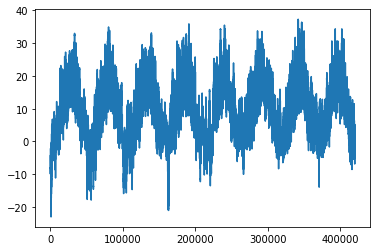

In [4]:
# Listing 10.3 Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

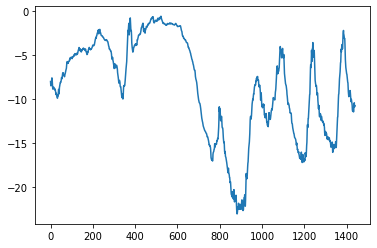

In [5]:
# Listing 10.4 Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440])

- Always look for periodicity in your data
  - Periodicity over multiple timescales is an important and very common property of timeseries data.
-  When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse

In [6]:
# Listing 10.5 Computing the number of samples we’ll use for each data split
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 10.2.1 Preparing the data

- problem
  - given data covering the previous five days and sampled once per hour
  - can we predict the temperature in 24 hours

In [7]:
# check data
import pandas as pd
raw_data_pd = pd.DataFrame(raw_data,columns=header[1:])
raw_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   "p (mbar)"         420451 non-null  float64
 1   "T (degC)"         420451 non-null  float64
 2   "Tpot (K)"         420451 non-null  float64
 3   "Tdew (degC)"      420451 non-null  float64
 4   "rh (%)"           420451 non-null  float64
 5   "VPmax (mbar)"     420451 non-null  float64
 6   "VPact (mbar)"     420451 non-null  float64
 7   "VPdef (mbar)"     420451 non-null  float64
 8   "sh (g/kg)"        420451 non-null  float64
 9   "H2OC (mmol/mol)"  420451 non-null  float64
 10  "rho (g/m**3)"     420451 non-null  float64
 11  "wv (m/s)"         420451 non-null  float64
 12  "max. wv (m/s)"    420451 non-null  float64
 13  "wd (deg)"         420451 non-null  float64
dtypes: float64(14)
memory usage: 44.9 MB


In [8]:
raw_data_pd.describe()

,"""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""","""H2OC (mmol/mol)""","""rho (g/m**3)""","""wv (m/s)""","""max. wv (m/s)""","""wd (deg)"""
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


In [9]:
# Listing 10.6 Normalizing the data
# only on train data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

- create a Dataset object 
  - that yields batches of data from the past five days along with a target temperature 24 hours in the future

In [10]:
# Understanding timeseries_dataset_from_array()
import numpy as np 
from tensorflow import keras
int_sequence = np.arange(10)
print(int_sequence)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)
for inputs, targets in dummy_dataset:
  print(inputs)
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))


[0 1 2 3 4 5 6 7 8 9]
tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int64)
[0, 1, 2] 3
[1, 2, 3] 4
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int64)
[2, 3, 4] 5
[3, 4, 5] 6
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64)
[4, 5, 6] 7


In [11]:
# Listing 10.7 Instantiating datasets for training, validation, and testing

# sampling_rate = 6
  # Observations will be sampled at one data point per hour
  # we will only keep one data point out of 6
sampling_rate = 6
# sequence_length = 120
  # Observations will go back 5 days (120 hours).
sequence_length = 120
# delay = sampling_rate * (sequence_length + 24 - 1)
  # The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
 
train_dataset = keras.utils.timeseries_dataset_from_array(
    # skip last entries from raw data
    raw_data[:-delay],
    # skip inital interies from raw data
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
 
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
 
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [12]:
# Listing 10.8 Inspecting the output of one of our datasets
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


### 10.2.2 A common-sense, non-machine learning baseline

- common-sense baselines
  -  predict that the temperature 24 hours from now will be equal to the temperature right now.

In [14]:
# Listing 10.9 Computing the common-sense baseline MAE
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
 
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.39
Test MAE: 2.77


### 10.2.3 Let’s try a basic machine learning model

In [15]:
# Listing 10.10 Training and evaluating a densely connected model
from tensorflow import keras 
from tensorflow.keras import layers
 
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)
 
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") 

Epoch 1/10
819/819 [==============================] - 64s 77ms/step - loss: 13.0911 - mae: 2.7838 - val_loss: 11.4789 - val_mae: 2.6791
Epoch 2/10
819/819 [==============================] - 65s 80ms/step - loss: 9.1854 - mae: 2.3833 - val_loss: 9.8738 - val_mae: 2.4806
Epoch 3/10
819/819 [==============================] - 62s 75ms/step - loss: 8.4127 - mae: 2.2840 - val_loss: 10.1153 - val_mae: 2.5043
Epoch 4/10
819/819 [==============================] - 62s 75ms/step - loss: 7.9577 - mae: 2.2232 - val_loss: 10.0054 - val_mae: 2.4930
Epoch 5/10
819/819 [==============================] - 64s 78ms/step - loss: 7.6015 - mae: 2.1767 - val_loss: 11.2146 - val_mae: 2.6676
Epoch 6/10
819/819 [==============================] - 64s 78ms/step - loss: 7.3228 - mae: 2.1392 - val_loss: 12.9430 - val_mae: 2.8720
Epoch 7/10
819/819 [==============================] - 64s 78ms/step - loss: 7.1291 - mae: 2.1125 - val_loss: 11.1505 - val_mae: 2.6577
Epoch 8/10
819/819 [==============================] - 6

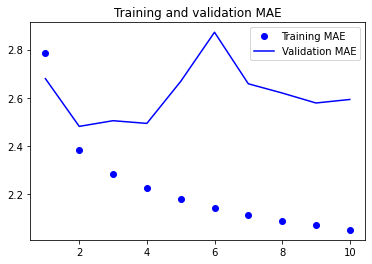

In [16]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

- It is not good than the simple baseline method

### 10.2.4 Let’s try a 1D convolutional model

- A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.
- 1D convnets
  - great fit for any sequence data that follows the translation invariance assumption
-  pick an initial window length of 24, so that
we look at 24 hours of data at a time (one cycle)

In [17]:
# Temperature problem with 1D convents

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
             keras.callbacks.ModelCheckpoint("jena_conv.keras",save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)
 
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 100s 121ms/step - loss: 22.7003 - mae: 3.7092 - val_loss: 15.3657 - val_mae: 3.0913
Epoch 2/10
819/819 [==============================] - 100s 121ms/step - loss: 15.2714 - mae: 3.0870 - val_loss: 14.7151 - val_mae: 3.0497
Epoch 3/10
819/819 [==============================] - 101s 123ms/step - loss: 14.1115 - mae: 2.9647 - val_loss: 15.8357 - val_mae: 3.1570
Epoch 4/10
819/819 [==============================] - 110s 134ms/step - loss: 13.2043 - mae: 2.8704 - val_loss: 16.1043 - val_mae: 3.1852
Epoch 5/10
819/819 [==============================] - 106s 129ms/step - loss: 12.4053 - mae: 2.7848 - val_loss: 15.9923 - val_mae: 3.1553
Epoch 6/10
819/819 [==============================] - 105s 127ms/step - loss: 11.8741 - mae: 2.7253 - val_loss: 15.1538 - val_mae: 3.0656
Epoch 7/10
819/819 [==============================] - 112s 136ms/step - loss: 11.4072 - mae: 2.6745 - val_loss: 15.0280 - val_mae: 3.0573
Epoch 8/10
819/819 [==============

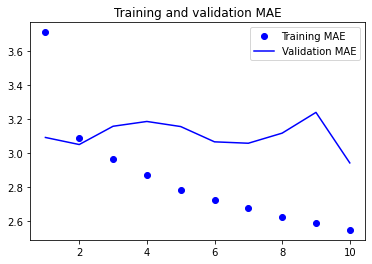

In [18]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

- even worse results
- reasons
  - First, weather data doesn’t quite respect the translation invariance assumption. While the data does
feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
  - Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.


### 10.2.5 A first recurrent baseline

- The densely connected approach first flattened the timeseries, which removed the notion of time from the input data.
- The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information

In [19]:
# long short term memory
# Listing 10.12 A simple LSTM-based model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
 
callbacks = [
             keras.callbacks.ModelCheckpoint("jena_lstm.keras",save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 125s 149ms/step - loss: 46.4668 - mae: 4.9417 - val_loss: 13.0507 - val_mae: 2.7360
Epoch 2/10
819/819 [==============================] - 120s 146ms/step - loss: 10.9823 - mae: 2.5648 - val_loss: 9.5309 - val_mae: 2.3986
Epoch 3/10
819/819 [==============================] - 120s 147ms/step - loss: 9.6552 - mae: 2.4160 - val_loss: 9.3241 - val_mae: 2.3629
Epoch 4/10
819/819 [==============================] - 120s 147ms/step - loss: 9.1650 - mae: 2.3525 - val_loss: 9.5549 - val_mae: 2.3939
Epoch 5/10
819/819 [==============================] - 120s 146ms/step - loss: 8.8289 - mae: 2.3062 - val_loss: 9.5379 - val_mae: 2.4026
Epoch 6/10
819/819 [==============================] - 119s 145ms/step - loss: 8.6090 - mae: 2.2768 - val_loss: 9.6574 - val_mae: 2.4107
Epoch 7/10
819/819 [==============================] - 117s 143ms/step - loss: 8.3927 - mae: 2.2493 - val_loss: 9.6542 - val_mae: 2.4156
Epoch 8/10
819/819 [=========================

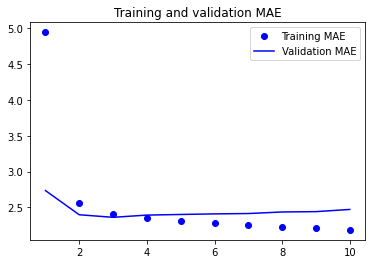

In [20]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

- LSTM based model performed somewhat batter

## 10.3 Understanding recurrent neural networks

- Neural networks in-general are memory less
  - have to show the entire sequence to the network at once
  - feedforward networks
- recurrent neural network (RNN)
  - processes sequences by iterating through the sequence elements and maintaining a state that contains information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop
  - state of the RNN is reset between processing two different, independent sequences
  - data point is no longer processed in a single step rather, the network internally loops over sequence elements


In [13]:
# Listing 10.13 Pseudocode RNN
'''
state_t = 0
for input_t in input_sequence:
  output_t = f(input_t, state_t)
  state_t = output_t 
'''

'\nstate_t = 0\nfor input_t in input_sequence:\n  output_t = f(input_t, state_t)\n  state_t = output_t \n'

In [22]:
# Listing 10.14 More-detailed pseudocode for the RNN
'''
state_t = 0
for input_t in input_sequence:
  output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
  state_t = output_t
'''

'\nstate_t = 0\nfor input_t in input_sequence:\n  output_t = activation(dot(W, input_t) + dot(U, state_t) + b)\n  state_t = output_t\n'

In [21]:
# Listing 10.15 NumPy implementation of a simple RNN
import numpy as np
timesteps = 100
input_features = 32
output_features = 64

# numpy array of shape (100.32)
inputs = np.random.random((timesteps, input_features))
# numpy array of shape (64,)
state_t = np.zeros((output_features,))
# numpy array of shape (64,32)
W = np.random.random((output_features, input_features))
# numpy array of shape (64,32)
U = np.random.random((output_features, output_features))
# numpy array of shape (64,)
b = np.random.random((output_features,))
# store output of every 
successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0) 

- A simple RNN, unrolled over time

![A simple RNN, unrolled over time](./snaps/10.1.PNG)

### 10.3.1 A recurrent layer in Keras

- SimpleRNN processes batches of sequences, like all other Keras layers, not a single sequence

In [23]:
# Listing 10.16 An RNN layer that can process sequences of any length
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

- All recurrent layers in Keras can be run in two different modes
  - they can return either full sequences of successive outputs for each timestep
  - or return only the last output for each input sequence

In [24]:
# Listing 10.17 An RNN layer that returns only its last output step
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [25]:
# Listing 10.18 An RNN layer that returns its full output sequence
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [26]:
# Listing 10.19 Stacking RNN layers
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

- SimpleRNN has a major issue: 
  - although it should theoretically be able to retain at time t information about inputs seen many timesteps before such long-term dependencies prove impossible to learn in practice.
    - This is due to the vanishing gradient problem, an effect that is similar to what is observed with non recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable

- recurrent layers
  - simple RNN
  - LSTM
  - GRU

- Long Short-Term Memory (LSTM)
  - adds a way to carry information across many timesteps
  - it saves information for later, thus preventing older signals from gradually vanishing during processing
  - additional data flow that carries information across timesteps.
  - it will be combined with the input connection and the recurrent connection
  - it will affect the state being sent to the next timestep
  - carry dataflow is a way to modulate the next output and the next state

In [27]:
# Listing 10.20 Pseudocode details of the LSTM architecture
'''
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
c_t+1 = i_t * k_t + c_t * f_t
'''

'\noutput_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)\ni_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)\nf_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)\nk_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)\nc_t+1 = i_t * k_t + c_t * f_t\n'

![Anatomy of an LSTM](./snaps/10.2.PNG)

- allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem

## 10.4 Advanced use of recurrent neural networks

- Recurrent dropout
  - This is a variant of dropout, used to fight overfitting in recurrent layers
- Stacking recurrent layers
  - This increases the representational power of the model (at the cost of higher computational loads)
- Bidirectional recurrent layers
  - These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.


### 10.4.1 Using recurrent dropout to fight overfitting

- applying dropout before a recurrent layer hinders learning rather than helping with regularization
- the same dropout mask should be applied at every timestep,

In [28]:
# Listing 10.22 Training and evaluating a dropout-regularized LSTM
from tensorflow import keras 
from tensorflow.keras import layers
sequence_length = 120
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=50,
 validation_data=val_dataset,
 callbacks=callbacks) 

Epoch 1/50
819/819 [==============================] - 218s 263ms/step - loss: 27.0399 - mae: 3.8319 - val_loss: 9.8121 - val_mae: 2.4090
Epoch 2/50
819/819 [==============================] - 217s 265ms/step - loss: 14.7682 - mae: 2.9846 - val_loss: 9.4381 - val_mae: 2.3707
Epoch 3/50
819/819 [==============================] - 219s 267ms/step - loss: 14.0446 - mae: 2.9051 - val_loss: 9.3358 - val_mae: 2.3602
Epoch 4/50
819/819 [==============================] - 216s 263ms/step - loss: 13.4993 - mae: 2.8446 - val_loss: 9.5359 - val_mae: 2.3806
Epoch 5/50
819/819 [==============================] - 220s 268ms/step - loss: 13.0274 - mae: 2.7942 - val_loss: 9.3369 - val_mae: 2.3562
Epoch 6/50
819/819 [==============================] - 224s 274ms/step - loss: 12.6240 - mae: 2.7519 - val_loss: 9.1643 - val_mae: 2.3273
Epoch 7/50
819/819 [==============================] - 227s 277ms/step - loss: 12.3044 - mae: 2.7139 - val_loss: 9.5815 - val_mae: 2.4018
Epoch 8/50
819/819 [=====================

In [29]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 30s 73ms/step - loss: 10.8840 - mae: 2.6096
Test MAE: 2.61


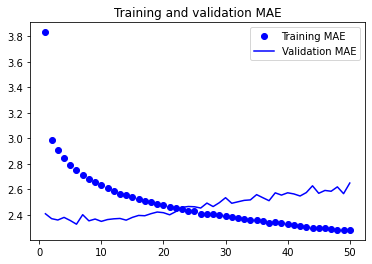

In [30]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#### RNN runtime performance

In [31]:
# Use RNN with out loop
'''
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
'''

'\ninputs = keras.Input(shape=(sequence_length, num_features))\nx = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)\n'

### 10.4.2 Stacking recurrent layers

- it’s generally a good idea to increase the capacity of your model until overfitting becomes the primary obstacle

In [33]:
# Listing 10.23 Training and evaluating a dropout-regularized, stacked GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
 
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 335s 403ms/step - loss: 26.4530 - mae: 3.7845 - val_loss: 9.3692 - val_mae: 2.3668
Epoch 2/10
819/819 [==============================] - 331s 404ms/step - loss: 14.0618 - mae: 2.9067 - val_loss: 9.4144 - val_mae: 2.3879
Epoch 3/10
819/819 [==============================] - 328s 400ms/step - loss: 13.2463 - mae: 2.8195 - val_loss: 8.8697 - val_mae: 2.3196
Epoch 4/10
819/819 [==============================] - 327s 399ms/step - loss: 12.6914 - mae: 2.7640 - val_loss: 9.2331 - val_mae: 2.3590
Epoch 5/10
819/819 [==============================] - 327s 398ms/step - loss: 12.2541 - mae: 2.7127 - val_loss: 8.7796 - val_mae: 2.3054
Epoch 6/10
819/819 [==============================] - 326s 398ms/step - loss: 11.8621 - mae: 2.6698 - val_loss: 9.4274 - val_mae: 2.3998
Epoch 7/10
819/819 [==============================] - 327s 399ms/step - loss: 11.4462 - mae: 2.6253 - val_loss: 9.7200 - val_mae: 2.4456
Epoch 8/10
819/819 [=====================

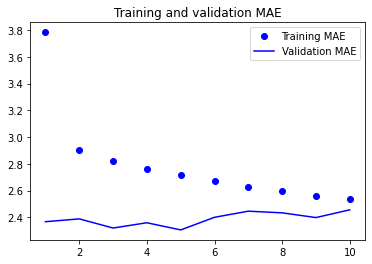

In [34]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 10.4.3 Using bidirectional RNNs

- RNNs are notably order-dependent:
  - they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. 
- A bidirectional RNN exploits the order sensitivity of RNNs:
  - it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction and then merges their representations

In [35]:
# Listing 10.24 Training and evaluating a bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 174s 207ms/step - loss: 25.7457 - mae: 3.6449 - val_loss: 10.9898 - val_mae: 2.5694
Epoch 2/10
819/819 [==============================] - 173s 211ms/step - loss: 9.5353 - mae: 2.4135 - val_loss: 9.7006 - val_mae: 2.4199
Epoch 3/10
819/819 [==============================] - 180s 220ms/step - loss: 8.5745 - mae: 2.2869 - val_loss: 9.8522 - val_mae: 2.4297
Epoch 4/10
819/819 [==============================] - 180s 219ms/step - loss: 8.1102 - mae: 2.2212 - val_loss: 10.0395 - val_mae: 2.4547
Epoch 5/10
819/819 [==============================] - 176s 215ms/step - loss: 7.7181 - mae: 2.1672 - val_loss: 10.3787 - val_mae: 2.4912
Epoch 6/10
819/819 [==============================] - 171s 208ms/step - loss: 7.4061 - mae: 2.1228 - val_loss: 10.3708 - val_mae: 2.4965
Epoch 7/10
819/819 [==============================] - 170s 208ms/step - loss: 7.1203 - mae: 2.0834 - val_loss: 10.8354 - val_mae: 2.5601
Epoch 8/10
819/819 [======================

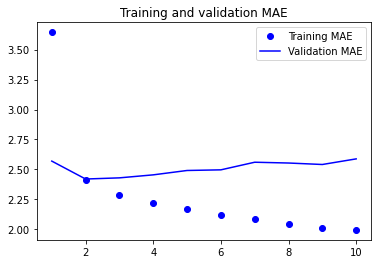

In [36]:
# Listing 10.11 Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

- bideirectinal RNNs are more usefull where order of data does not matter such as language processing

### 10.4.4 Going even further

- Improve performance by
  - Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout. The current choices are largely arbitrary and thus probably suboptimal.
  - Adjust the learning rate used by the RMSprop optimizer, or try a different optimizer.
  - Try using a stack of Dense layers as the regressor on top of the recurrent layer, instead of a single Dense layer.
  - Improve the input to the model
    - try using longer or shorter sequences
    - a different sampling rate
    - start doing feature engineering.

#### Markets and machine learning

## The END